# Betti and Steenrod curves

## Introduction
A **filtration** consists of a total order on the simplices $\{\sigma_0, \dots ,\sigma_{N}\}$ of a finite simplicial complex $X$ such that $X[n] = \{\sigma_i \,|\ i \leq n\}$ is a subcomplex of $X$.

The **d-Betti curve** of a filtration is the function 

$$\beta_d : \{0,\dots,N\} \to \mathbb N$$

sending $i$ to the rank of the [relative cohomology](https://en.wikipedia.org/wiki/Simplicial_homology) vector space

$$H^d(X,\,X[N-i]\,;\mathbb F_2).$$

The **(k,d)-Steenrod curve** of a filtration is the function 

$$\gamma^k_d : \{0,\dots,N\} \to \mathbb N$$

sending $i$ to the rank of the [Steenrod square](https://en.wikipedia.org/wiki/Steenrod_algebra) 

$$Sq^k : H^d(X,\,X[N-i]\,;\mathbb F_2) \to H^{d+k}(X,\,X[N-i]\,;\mathbb F_2).$$

We now describe how to construct these invariants given any filtration $X$. Let $\partial$ be the matrix representing the boundary map 

$$C_*(X;\mathbb F_2) \to C_{*-1}(X;\mathbb F_2)$$

with respect to the canonical basis defined by the filtration. Following De Silva, Morozov, and Vejdemo-Johansson [[1]](https://www.mrzv.org/publications/dualities-persistence/manuscript/) we can compute representatives of $H^d(X,\,X[N-i]\,;\mathbb F_2)$ which are natural with respect to the inclusion maps $X[N-i] \leftarrow X[N-(i+1)]$ by the following procedure: consider the matrix

$$[\delta]_{p,q} = [\partial]_{N-q,N-p}$$
and obtain a factorization of the form 
$$R = [\delta] V$$

where $R$ is a reduced matrix and $V$ is an upper-triangular invertible matrix.

The **barcode** of the filtration is defined to be the collection of pairs $(b,d)$ such that 
$R_{b,d}$ is a pivot or $d = +\infty$, the $b$-th column is zero, and no pivot of $R$ has $b$ as its row coordinate.

A basis for $H^*(X,\,X[N-i]\,;\mathbb F_2)$ is in bijection with the number of bars $(b,d)$ satisfying $b \leq i < d$. The bijection takes a bar $(b,d)$ to the vector $R_d$ and a bar $(b,+\infty)$ to the vector $V_b$. We refer to the integers $b$ and $d$ as the birth and death times of the class represented by its associated cocycle.

From the barcode we can easily obtain the Betti curves. We now describe
how to obtain the Steenrod curves.

Following Medina-Mardones [[2]](https://arxiv.org/abs/1812.05031), we can effectively construct a cocycle representative of $Sq^k([\alpha])$ given a cocyle $\alpha$ representing it. We refer to this as the $k$-Steenrod representative of $[\alpha]$.

Let $R_{\leq n}$ denote the submatrix of $R$ containing the first $n$-columns. The non-zero columns in $R_{\leq n}$ define a basis of the image of $\delta$ restricted to $C^*(X,\,X[N-n]\,;\mathbb F_2)$. The value of the $(k,d)$-Steenrod curve on $i$ is equal to

$$ \mathrm{rank}(A_{\leq i}) - \mathrm{rank}(R_{\leq i})$$

where $A_{\leq i}$ equals $R_{\leq i}$ augmented by the matrix containing the column vectors of $k$-Steenrod representatives of degree $d$ classes born before or at time $i$.

In this notebook, we implement functions computing Betti and Steenrod curves and compute these invariants for certain filtrations of finite approximations of the [real projective space](https://en.wikipedia.org/wiki/Real_projective_space)

$$RP^\infty \supset \cdots \supset RP^2 \supset RP^1 \supset RP^0.$$

We recall that $H^*(RP^\infty;\mathbb F_2) = \mathbb F_2[x]$ with $|x| = 1$ and that 

$$Sq^k(x^n) = {n \choose k} x^{n+k}.$$

In [1]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

## Filtered simplicial complexes

In [2]:
rp2 = ((1,), (2,), (1, 2), (3,), (1, 3), (2, 3), (4,), (1, 4), (2, 4), (1, 2, 4), (3, 4), (2, 3, 4), (5,), (1, 5), (2, 5), (3, 5), (1, 3, 5), (2, 3, 5), (4, 5), (1, 4, 5), (6,), (1, 6), (2, 6), (1, 2, 6), (3, 6), (1, 3, 6), (4, 6), (3, 4, 6), (5, 6), (2, 5, 6), (4, 5, 6))
cone_rp2 = rp2 + ((9,),) + tuple([spx+(9,) for spx in rp2])
rp3 = ((1,),(2,),(1, 2),(3,),(1, 3),(2, 3),(1, 2, 3),(4,),(1, 4),(2, 4),(1, 2, 4),(3, 4),(1, 3, 4),(2, 3, 4),(1, 2, 3, 4),(5,),(1, 5),(2, 5),(1, 2, 5),(3, 5),(1, 3, 5),(2, 3, 5),(1, 2, 3, 5),(4, 5),(1, 4, 5),(3, 4, 5),(1, 3, 4, 5),(6,),(1, 6),(2, 6),(1, 2, 6),(4, 6),(1, 4, 6),(2, 4, 6),(1, 2, 4, 6),(5, 6),(1, 5, 6),(2, 5, 6),(1, 2, 5, 6),(4, 5, 6),(1, 4, 5, 6),(7,),(2, 7),(3, 7),(2, 3, 7),(4, 7),(2, 4, 7),(3, 4, 7),(2, 3, 4, 7),(8,),(2, 8),(3, 8),(2, 3, 8),(5, 8),(2, 5, 8),(3, 5, 8),(2, 3, 5, 8),(7, 8),(2, 7, 8),(3, 7, 8),(2, 3, 7, 8),(9,),(2, 9),(4, 9),(2, 4, 9),(6, 9),(2, 6, 9),(4, 6, 9),(2, 4, 6, 9),(7, 9),(2, 7, 9),(4, 7, 9),(2, 4, 7, 9),(8, 9),(10,),(2, 10),(5, 10),(2, 5, 10),(6, 10),(2, 6, 10),(5, 6, 10),(2, 5, 6, 10),(7, 10),(8, 10),(2, 8, 10),(5, 8, 10),(2, 5, 8, 10),(9, 10),(2, 9, 10),(6, 9, 10),(2, 6, 9, 10),(11,),(2, 11),(7, 11),(2, 7, 11),(8, 11),(2, 8, 11),(7, 8, 11),(2, 7, 8, 11),(9, 11),(2, 9, 11),(7, 9, 11),(2, 7, 9, 11),(10, 11),(2, 10, 11),(8, 10, 11),(2, 8, 10, 11),(9, 10, 11),(2, 9, 10, 11),(12,),(3, 12),(4, 12),(3, 4, 12),(5, 12),(3, 5, 12),(4, 5, 12),(3, 4, 5, 12),(7, 12),(3, 7, 12),(4, 7, 12),(3, 4, 7, 12),(8, 12),(3, 8, 12),(5, 8, 12),(3, 5, 8, 12),(9, 12),(8, 9, 12),(10, 12),(7, 10, 12),(9, 10, 12),(11, 12),(9, 11, 12),(10, 11, 12),(9, 10, 11, 12),(13,),(3, 13),(6, 13),(7, 13),(3, 7, 13),(8, 13),(3, 8, 13),(7, 8, 13),(3, 7, 8, 13),(9, 13),(6, 9, 13),(8, 9, 13),(10, 13),(6, 10, 13),(7, 10, 13),(9, 10, 13),(6, 9, 10, 13),(12, 13),(3, 12, 13),(7, 12, 13),(3, 7, 12, 13),(8, 12, 13),(3, 8, 12, 13),(9, 12, 13),(8, 9, 12, 13),(10, 12, 13),(7, 10, 12, 13),(9, 10, 12, 13),(14,),(4, 14),(5, 14),(4, 5, 14),(6, 14),(4, 6, 14),(5, 6, 14),(4, 5, 6, 14),(7, 14),(8, 14),(7, 8, 14),(9, 14),(4, 9, 14),(6, 9, 14),(4, 6, 9, 14),(8, 9, 14),(10, 14),(5, 10, 14),(6, 10, 14),(5, 6, 10, 14),(7, 10, 14),(11, 14),(7, 11, 14),(8, 11, 14),(7, 8, 11, 14),(12, 14),(4, 12, 14),(5, 12, 14),(4, 5, 12, 14),(11, 12, 14),(13, 14),(6, 13, 14),(7, 13, 14),(8, 13, 14),(7, 8, 13, 14),(9, 13, 14),(6, 9, 13, 14),(8, 9, 13, 14),(10, 13, 14),(6, 10, 13, 14),(7, 10, 13, 14),(15,),(4, 15),(7, 15),(4, 7, 15),(8, 15),(9, 15),(4, 9, 15),(7, 9, 15),(4, 7, 9, 15),(8, 9, 15),(10, 15),(7, 10, 15),(8, 10, 15),(11, 15),(8, 11, 15),(10, 11, 15),(8, 10, 11, 15),(12, 15),(4, 12, 15),(7, 12, 15),(4, 7, 12, 15),(10, 12, 15),(7, 10, 12, 15),(11, 12, 15),(10, 11, 12, 15),(14, 15),(4, 14, 15),(8, 14, 15),(9, 14, 15),(4, 9, 14, 15),(8, 9, 14, 15),(11, 14, 15),(8, 11, 14, 15),(12, 14, 15),(4, 12, 14, 15),(11, 12, 14, 15),(16,),(5, 16),(7, 16),(8, 16),(5, 8, 16),(9, 16),(7, 9, 16),(8, 9, 16),(10, 16),(5, 10, 16),(7, 10, 16),(8, 10, 16),(5, 8, 10, 16),(11, 16),(7, 11, 16),(9, 11, 16),(7, 9, 11, 16),(12, 16),(5, 12, 16),(8, 12, 16),(5, 8, 12, 16),(9, 12, 16),(8, 9, 12, 16),(11, 12, 16),(9, 11, 12, 16),(14, 16),(5, 14, 16),(7, 14, 16),(10, 14, 16),(5, 10, 14, 16),(7, 10, 14, 16),(11, 14, 16),(7, 11, 14, 16),(12, 14, 16),(5, 12, 14, 16),(11, 12, 14, 16),(15, 16),(7, 15, 16),(8, 15, 16),(9, 15, 16),(7, 9, 15, 16),(8, 9, 15, 16),(10, 15, 16),(7, 10, 15, 16),(8, 10, 15, 16))
cone_rp3 = rp3 + ((20,),) + tuple([spx+(20,) for spx in rp3])
rp4 = ((1,), (2,), (1, 2), (3,), (1, 3), (2, 3), (4,), (1, 4), (2, 4), (1, 2, 4), (3, 4), (1, 3, 4), (5,), (1, 5), (2, 5), (1, 2, 5), (3, 5), (2, 3, 5), (4, 5), (1, 4, 5), (2, 4, 5), (1, 2, 4, 5), (6,), (1, 6), (2, 6), (3, 6), (4, 6), (2, 4, 6), (3, 4, 6), (5, 6), (1, 5, 6), (3, 5, 6), (7,), (1, 7), (2, 7), (1, 2, 7), (3, 7), (2, 3, 7), (4, 7), (3, 4, 7), (5, 7), (4, 5, 7), (6, 7), (1, 6, 7), (3, 6, 7), (4, 6, 7), (3, 4, 6, 7), (8,), (1, 8), (2, 8), (1, 2, 8), (3, 8), (1, 3, 8), (4, 8), (5, 8), (3, 5, 8), (4, 5, 8), (6, 8), (2, 6, 8), (3, 6, 8), (5, 6, 8), (3, 5, 6, 8), (7, 8), (1, 7, 8), (2, 7, 8), (1, 2, 7, 8), (4, 7, 8), (5, 7, 8), (4, 5, 7, 8), (9,), (1, 9), (2, 9), (3, 9), (1, 3, 9), (2, 3, 9), (4, 9), (2, 4, 9), (5, 9), (1, 5, 9), (6, 9), (1, 6, 9), (2, 6, 9), (4, 6, 9), (2, 4, 6, 9), (5, 6, 9), (1, 5, 6, 9), (7, 9), (2, 7, 9), (3, 7, 9), (2, 3, 7, 9), (5, 7, 9), (8, 9), (1, 8, 9), (3, 8, 9), (1, 3, 8, 9), (4, 8, 9), (10,), (1, 10), (2, 10), (3, 10), (1, 3, 10), (2, 3, 10), (4, 10), (1, 4, 10), (3, 4, 10), (1, 3, 4, 10), (5, 10), (2, 5, 10), (3, 5, 10), (2, 3, 5, 10), (6, 10), (1, 6, 10), (2, 6, 10), (7, 10), (1, 7, 10), (5, 7, 10), (6, 7, 10), (1, 6, 7, 10), (8, 10), (2, 8, 10), (4, 8, 10), (6, 8, 10), (2, 6, 8, 10), (9, 10), (4, 9, 10), (5, 9, 10), (7, 9, 10), (5, 7, 9, 10), (8, 9, 10), (4, 8, 9, 10), (11,), (1, 11), (2, 11), (1, 2, 11), (3, 11), (1, 3, 11), (4, 11), (1, 4, 11), (2, 4, 11), (1, 2, 4, 11), (3, 4, 11), (1, 3, 4, 11), (5, 11), (1, 5, 11), (2, 5, 11), (1, 2, 5, 11), (4, 5, 11), (1, 4, 5, 11), (2, 4, 5, 11), (1, 2, 4, 5, 11), (6, 11), (2, 6, 11), (3, 6, 11), (4, 6, 11), (2, 4, 6, 11), (3, 4, 6, 11), (7, 11), (3, 7, 11), (4, 7, 11), (3, 4, 7, 11), (5, 7, 11), (4, 5, 7, 11), (6, 7, 11), (3, 6, 7, 11), (4, 6, 7, 11), (3, 4, 6, 7, 11), (8, 11), (1, 8, 11), (2, 8, 11), (1, 2, 8, 11), (3, 8, 11), (1, 3, 8, 11), (6, 8, 11), (2, 6, 8, 11), (3, 6, 8, 11), (9, 11), (1, 9, 11), (3, 9, 11), (1, 3, 9, 11), (5, 9, 11), (1, 5, 9, 11), (7, 9, 11), (3, 7, 9, 11), (5, 7, 9, 11), (8, 9, 11), (1, 8, 9, 11), (3, 8, 9, 11), (1, 3, 8, 9, 11), (10, 11), (2, 10, 11), (5, 10, 11), (2, 5, 10, 11), (6, 10, 11), (2, 6, 10, 11), (7, 10, 11), (5, 7, 10, 11), (6, 7, 10, 11), (8, 10, 11), (2, 8, 10, 11), (6, 8, 10, 11), (2, 6, 8, 10, 11), (9, 10, 11), (5, 9, 10, 11), (7, 9, 10, 11), (5, 7, 9, 10, 11), (8, 9, 10, 11), (12,), (1, 12), (2, 12), (3, 12), (1, 3, 12), (2, 3, 12), (4, 12), (2, 4, 12), (5, 12), (2, 5, 12), (3, 5, 12), (2, 3, 5, 12), (4, 5, 12), (2, 4, 5, 12), (6, 12), (1, 6, 12), (2, 6, 12), (4, 6, 12), (2, 4, 6, 12), (7, 12), (1, 7, 12), (4, 7, 12), (5, 7, 12), (4, 5, 7, 12), (6, 7, 12), (1, 6, 7, 12), (4, 6, 7, 12), (8, 12), (1, 8, 12), (3, 8, 12), (1, 3, 8, 12), (4, 8, 12), (5, 8, 12), (3, 5, 8, 12), (4, 5, 8, 12), (7, 8, 12), (1, 7, 8, 12), (4, 7, 8, 12), (5, 7, 8, 12), (4, 5, 7, 8, 12), (9, 12), (1, 9, 12), (2, 9, 12), (3, 9, 12), (1, 3, 9, 12), (2, 3, 9, 12), (4, 9, 12), (2, 4, 9, 12), (6, 9, 12), (1, 6, 9, 12), (2, 6, 9, 12), (4, 6, 9, 12), (2, 4, 6, 9, 12), (8, 9, 12), (1, 8, 9, 12), (3, 8, 9, 12), (1, 3, 8, 9, 12), (4, 8, 9, 12), (10, 12), (1, 10, 12), (2, 10, 12), (3, 10, 12), (1, 3, 10, 12), (2, 3, 10, 12), (5, 10, 12), (2, 5, 10, 12), (3, 5, 10, 12), (2, 3, 5, 10, 12), (6, 10, 12), (1, 6, 10, 12), (2, 6, 10, 12), (7, 10, 12), (1, 7, 10, 12), (5, 7, 10, 12), (6, 7, 10, 12), (1, 6, 7, 10, 12), (11, 12), (2, 11, 12), (4, 11, 12), (2, 4, 11, 12), (5, 11, 12), (2, 5, 11, 12), (4, 5, 11, 12), (2, 4, 5, 11, 12), (6, 11, 12), (2, 6, 11, 12), (4, 6, 11, 12), (2, 4, 6, 11, 12), (7, 11, 12), (4, 7, 11, 12), (5, 7, 11, 12), (4, 5, 7, 11, 12), (6, 7, 11, 12), (4, 6, 7, 11, 12), (10, 11, 12), (2, 10, 11, 12), (5, 10, 11, 12), (2, 5, 10, 11, 12), (6, 10, 11, 12), (2, 6, 10, 11, 12), (7, 10, 11, 12), (5, 7, 10, 11, 12), (6, 7, 10, 11, 12), (13,), (1, 13), (2, 13), (1, 2, 13), (3, 13), (1, 3, 13), (4, 13), (1, 4, 13), (2, 4, 13), (1, 2, 4, 13), (3, 4, 13), (1, 3, 4, 13), (5, 13), (3, 5, 13), (6, 13), (2, 6, 13), (3, 6, 13), (4, 6, 13), (2, 4, 6, 13), (3, 4, 6, 13), (5, 6, 13), (3, 5, 6, 13), (7, 13), (1, 7, 13), (2, 7, 13), (1, 2, 7, 13), (5, 7, 13), (8, 13), (1, 8, 13), (2, 8, 13), (1, 2, 8, 13), (3, 8, 13), (1, 3, 8, 13), (5, 8, 13), (3, 5, 8, 13), (6, 8, 13), (2, 6, 8, 13), (3, 6, 8, 13), (5, 6, 8, 13), (3, 5, 6, 8, 13), (7, 8, 13), (1, 7, 8, 13), (2, 7, 8, 13), (1, 2, 7, 8, 13), (5, 7, 8, 13), (9, 13), (2, 9, 13), (4, 9, 13), (2, 4, 9, 13), (5, 9, 13), (6, 9, 13), (2, 6, 9, 13), (4, 6, 9, 13), (2, 4, 6, 9, 13), (5, 6, 9, 13), (7, 9, 13), (2, 7, 9, 13), (5, 7, 9, 13), (10, 13), (1, 10, 13), (3, 10, 13), (1, 3, 10, 13), (4, 10, 13), (1, 4, 10, 13), (3, 4, 10, 13), (1, 3, 4, 10, 13), (5, 10, 13), (3, 5, 10, 13), (7, 10, 13), (1, 7, 10, 13), (5, 7, 10, 13), (9, 10, 13), (4, 9, 10, 13), (5, 9, 10, 13), (7, 9, 10, 13), (5, 7, 9, 10, 13), (11, 13), (1, 11, 13), (2, 11, 13), (1, 2, 11, 13), (3, 11, 13), (1, 3, 11, 13), (4, 11, 13), (1, 4, 11, 13), (2, 4, 11, 13), (1, 2, 4, 11, 13), (3, 4, 11, 13), (1, 3, 4, 11, 13), (6, 11, 13), (2, 6, 11, 13), (3, 6, 11, 13), (4, 6, 11, 13), (2, 4, 6, 11, 13), (3, 4, 6, 11, 13), (8, 11, 13), (1, 8, 11, 13), (2, 8, 11, 13), (1, 2, 8, 11, 13), (3, 8, 11, 13), (1, 3, 8, 11, 13), (6, 8, 11, 13), (2, 6, 8, 11, 13), (3, 6, 8, 11, 13), (12, 13), (1, 12, 13), (3, 12, 13), (1, 3, 12, 13), (5, 12, 13), (3, 5, 12, 13), (7, 12, 13), (1, 7, 12, 13), (5, 7, 12, 13), (8, 12, 13), (1, 8, 12, 13), (3, 8, 12, 13), (1, 3, 8, 12, 13), (5, 8, 12, 13), (3, 5, 8, 12, 13), (7, 8, 12, 13), (1, 7, 8, 12, 13), (5, 7, 8, 12, 13), (10, 12, 13), (1, 10, 12, 13), (3, 10, 12, 13), (1, 3, 10, 12, 13), (5, 10, 12, 13), (3, 5, 10, 12, 13), (7, 10, 12, 13), (1, 7, 10, 12, 13), (5, 7, 10, 12, 13), (14,), (1, 14), (2, 14), (1, 2, 14), (3, 14), (2, 3, 14), (4, 14), (1, 4, 14), (2, 4, 14), (1, 2, 4, 14), (5, 14), (1, 5, 14), (2, 5, 14), (1, 2, 5, 14), (3, 5, 14), (2, 3, 5, 14), (4, 5, 14), (1, 4, 5, 14), (2, 4, 5, 14), (1, 2, 4, 5, 14), (6, 14), (1, 6, 14), (3, 6, 14), (5, 6, 14), (1, 5, 6, 14), (3, 5, 6, 14), (7, 14), (1, 7, 14), (2, 7, 14), (1, 2, 7, 14), (3, 7, 14), (2, 3, 7, 14), (6, 7, 14), (1, 6, 7, 14), (3, 6, 7, 14), (8, 14), (3, 8, 14), (4, 8, 14), (5, 8, 14), (3, 5, 8, 14), (4, 5, 8, 14), (6, 8, 14), (3, 6, 8, 14), (5, 6, 8, 14), (3, 5, 6, 8, 14), (9, 14), (2, 9, 14), (3, 9, 14), (2, 3, 9, 14), (4, 9, 14), (2, 4, 9, 14), (7, 9, 14), (2, 7, 9, 14), (3, 7, 9, 14), (2, 3, 7, 9, 14), (8, 9, 14), (3, 8, 9, 14), (4, 8, 9, 14), (10, 14), (1, 10, 14), (4, 10, 14), (1, 4, 10, 14), (6, 10, 14), (1, 6, 10, 14), (7, 10, 14), (1, 7, 10, 14), (6, 7, 10, 14), (1, 6, 7, 10, 14), (8, 10, 14), (4, 8, 10, 14), (6, 8, 10, 14), (9, 10, 14), (4, 9, 10, 14), (7, 9, 10, 14), (8, 9, 10, 14), (4, 8, 9, 10, 14), (11, 14), (3, 11, 14), (6, 11, 14), (3, 6, 11, 14), (7, 11, 14), (3, 7, 11, 14), (6, 7, 11, 14), (3, 6, 7, 11, 14), (8, 11, 14), (3, 8, 11, 14), (6, 8, 11, 14), (3, 6, 8, 11, 14), (9, 11, 14), (3, 9, 11, 14), (7, 9, 11, 14), (3, 7, 9, 11, 14), (8, 9, 11, 14), (3, 8, 9, 11, 14), (10, 11, 14), (6, 10, 11, 14), (7, 10, 11, 14), (6, 7, 10, 11, 14), (8, 10, 11, 14), (6, 8, 10, 11, 14), (9, 10, 11, 14), (7, 9, 10, 11, 14), (8, 9, 10, 11, 14), (12, 14), (2, 12, 14), (3, 12, 14), (2, 3, 12, 14), (4, 12, 14), (2, 4, 12, 14), (5, 12, 14), (2, 5, 12, 14), (3, 5, 12, 14), (2, 3, 5, 12, 14), (4, 5, 12, 14), (2, 4, 5, 12, 14), (8, 12, 14), (3, 8, 12, 14), (4, 8, 12, 14), (5, 8, 12, 14), (3, 5, 8, 12, 14), (4, 5, 8, 12, 14), (9, 12, 14), (2, 9, 12, 14), (3, 9, 12, 14), (2, 3, 9, 12, 14), (4, 9, 12, 14), (2, 4, 9, 12, 14), (8, 9, 12, 14), (3, 8, 9, 12, 14), (4, 8, 9, 12, 14), (13, 14), (1, 13, 14), (2, 13, 14), (1, 2, 13, 14), (4, 13, 14), (1, 4, 13, 14), (2, 4, 13, 14), (1, 2, 4, 13, 14), (7, 13, 14), (1, 7, 13, 14), (2, 7, 13, 14), (1, 2, 7, 13, 14), (9, 13, 14), (2, 9, 13, 14), (4, 9, 13, 14), (2, 4, 9, 13, 14), (7, 9, 13, 14), (2, 7, 9, 13, 14), (10, 13, 14), (1, 10, 13, 14), (4, 10, 13, 14), (1, 4, 10, 13, 14), (7, 10, 13, 14), (1, 7, 10, 13, 14), (9, 10, 13, 14), (4, 9, 10, 13, 14), (7, 9, 10, 13, 14), (15,), (1, 15), (2, 15), (1, 2, 15), (3, 15), (2, 3, 15), (4, 15), (3, 4, 15), (5, 15), (1, 5, 15), (2, 5, 15), (1, 2, 5, 15), (3, 5, 15), (2, 3, 5, 15), (6, 15), (1, 6, 15), (3, 6, 15), (4, 6, 15), (3, 4, 6, 15), (5, 6, 15), (1, 5, 6, 15), (3, 5, 6, 15), (7, 15), (1, 7, 15), (2, 7, 15), (1, 2, 7, 15), (3, 7, 15), (2, 3, 7, 15), (4, 7, 15), (3, 4, 7, 15), (6, 7, 15), (1, 6, 7, 15), (3, 6, 7, 15), (4, 6, 7, 15), (3, 4, 6, 7, 15), (8, 15), (1, 8, 15), (2, 8, 15), (1, 2, 8, 15), (4, 8, 15), (7, 8, 15), (1, 7, 8, 15), (2, 7, 8, 15), (1, 2, 7, 8, 15), (4, 7, 8, 15), (9, 15), (1, 9, 15), (4, 9, 15), (5, 9, 15), (1, 5, 9, 15), (6, 9, 15), (1, 6, 9, 15), (4, 6, 9, 15), (5, 6, 9, 15), (1, 5, 6, 9, 15), (8, 9, 15), (1, 8, 9, 15), (4, 8, 9, 15), (10, 15), (2, 10, 15), (3, 10, 15), (2, 3, 10, 15), (4, 10, 15), (3, 4, 10, 15), (5, 10, 15), (2, 5, 10, 15), (3, 5, 10, 15), (2, 3, 5, 10, 15), (8, 10, 15), (2, 8, 10, 15), (4, 8, 10, 15), (9, 10, 15), (4, 9, 10, 15), (5, 9, 10, 15), (8, 9, 10, 15), (4, 8, 9, 10, 15), (11, 15), (1, 11, 15), (2, 11, 15), (1, 2, 11, 15), (5, 11, 15), (1, 5, 11, 15), (2, 5, 11, 15), (1, 2, 5, 11, 15), (8, 11, 15), (1, 8, 11, 15), (2, 8, 11, 15), (1, 2, 8, 11, 15), (9, 11, 15), (1, 9, 11, 15), (5, 9, 11, 15), (1, 5, 9, 11, 15), (8, 9, 11, 15), (1, 8, 9, 11, 15), (10, 11, 15), (2, 10, 11, 15), (5, 10, 11, 15), (2, 5, 10, 11, 15), (8, 10, 11, 15), (2, 8, 10, 11, 15), (9, 10, 11, 15), (5, 9, 10, 11, 15), (8, 9, 10, 11, 15), (12, 15), (1, 12, 15), (4, 12, 15), (6, 12, 15), (1, 6, 12, 15), (4, 6, 12, 15), (7, 12, 15), (1, 7, 12, 15), (4, 7, 12, 15), (6, 7, 12, 15), (1, 6, 7, 12, 15), (4, 6, 7, 12, 15), (8, 12, 15), (1, 8, 12, 15), (4, 8, 12, 15), (7, 8, 12, 15), (1, 7, 8, 12, 15), (4, 7, 8, 12, 15), (9, 12, 15), (1, 9, 12, 15), (4, 9, 12, 15), (6, 9, 12, 15), (1, 6, 9, 12, 15), (4, 6, 9, 12, 15), (8, 9, 12, 15), (1, 8, 9, 12, 15), (4, 8, 9, 12, 15), (13, 15), (3, 13, 15), (4, 13, 15), (3, 4, 13, 15), (5, 13, 15), (3, 5, 13, 15), (6, 13, 15), (3, 6, 13, 15), (4, 6, 13, 15), (3, 4, 6, 13, 15), (5, 6, 13, 15), (3, 5, 6, 13, 15), (9, 13, 15), (4, 9, 13, 15), (5, 9, 13, 15), (6, 9, 13, 15), (4, 6, 9, 13, 15), (5, 6, 9, 13, 15), (10, 13, 15), (3, 10, 13, 15), (4, 10, 13, 15), (3, 4, 10, 13, 15), (5, 10, 13, 15), (3, 5, 10, 13, 15), (9, 10, 13, 15), (4, 9, 10, 13, 15), (5, 9, 10, 13, 15), (14, 15), (1, 14, 15), (2, 14, 15), (1, 2, 14, 15), (3, 14, 15), (2, 3, 14, 15), (5, 14, 15), (1, 5, 14, 15), (2, 5, 14, 15), (1, 2, 5, 14, 15), (3, 5, 14, 15), (2, 3, 5, 14, 15), (6, 14, 15), (1, 6, 14, 15), (3, 6, 14, 15), (5, 6, 14, 15), (1, 5, 6, 14, 15), (3, 5, 6, 14, 15), (7, 14, 15), (1, 7, 14, 15), (2, 7, 14, 15), (1, 2, 7, 14, 15), (3, 7, 14, 15), (2, 3, 7, 14, 15), (6, 7, 14, 15), (1, 6, 7, 14, 15), (3, 6, 7, 14, 15), (16,), (1, 16), (2, 16), (3, 16), (1, 3, 16), (2, 3, 16), (4, 16), (1, 4, 16), (3, 4, 16), (1, 3, 4, 16), (5, 16), (1, 5, 16), (4, 5, 16), (1, 4, 5, 16), (6, 16), (1, 6, 16), (2, 6, 16), (5, 6, 16), (1, 5, 6, 16), (7, 16), (2, 7, 16), (3, 7, 16), (2, 3, 7, 16), (4, 7, 16), (3, 4, 7, 16), (5, 7, 16), (4, 5, 7, 16), (8, 16), (2, 8, 16), (4, 8, 16), (5, 8, 16), (4, 5, 8, 16), (6, 8, 16), (2, 6, 8, 16), (5, 6, 8, 16), (7, 8, 16), (2, 7, 8, 16), (4, 7, 8, 16), (5, 7, 8, 16), (4, 5, 7, 8, 16), (9, 16), (1, 9, 16), (2, 9, 16), (3, 9, 16), (1, 3, 9, 16), (2, 3, 9, 16), (5, 9, 16), (1, 5, 9, 16), (6, 9, 16), (1, 6, 9, 16), (2, 6, 9, 16), (5, 6, 9, 16), (1, 5, 6, 9, 16), (7, 9, 16), (2, 7, 9, 16), (3, 7, 9, 16), (2, 3, 7, 9, 16), (5, 7, 9, 16), (10, 16), (1, 10, 16), (2, 10, 16), (3, 10, 16), (1, 3, 10, 16), (2, 3, 10, 16), (4, 10, 16), (1, 4, 10, 16), (3, 4, 10, 16), (1, 3, 4, 10, 16), (6, 10, 16), (1, 6, 10, 16), (2, 6, 10, 16), (8, 10, 16), (2, 8, 10, 16), (4, 8, 10, 16), (6, 8, 10, 16), (2, 6, 8, 10, 16), (11, 16), (1, 11, 16), (3, 11, 16), (1, 3, 11, 16), (4, 11, 16), (1, 4, 11, 16), (3, 4, 11, 16), (1, 3, 4, 11, 16), (5, 11, 16), (1, 5, 11, 16), (4, 5, 11, 16), (1, 4, 5, 11, 16), (7, 11, 16), (3, 7, 11, 16), (4, 7, 11, 16), (3, 4, 7, 11, 16), (5, 7, 11, 16), (4, 5, 7, 11, 16), (9, 11, 16), (1, 9, 11, 16), (3, 9, 11, 16), (1, 3, 9, 11, 16), (5, 9, 11, 16), (1, 5, 9, 11, 16), (7, 9, 11, 16), (3, 7, 9, 11, 16), (5, 7, 9, 11, 16), (12, 16), (1, 12, 16), (2, 12, 16), (3, 12, 16), (1, 3, 12, 16), (2, 3, 12, 16), (6, 12, 16), (1, 6, 12, 16), (2, 6, 12, 16), (9, 12, 16), (1, 9, 12, 16), (2, 9, 12, 16), (3, 9, 12, 16), (1, 3, 9, 12, 16), (2, 3, 9, 12, 16), (6, 9, 12, 16), (1, 6, 9, 12, 16), (2, 6, 9, 12, 16), (10, 12, 16), (1, 10, 12, 16), (2, 10, 12, 16), (3, 10, 12, 16), (1, 3, 10, 12, 16), (2, 3, 10, 12, 16), (6, 10, 12, 16), (1, 6, 10, 12, 16), (2, 6, 10, 12, 16), (13, 16), (2, 13, 16), (5, 13, 16), (6, 13, 16), (2, 6, 13, 16), (5, 6, 13, 16), (7, 13, 16), (2, 7, 13, 16), (5, 7, 13, 16), (8, 13, 16), (2, 8, 13, 16), (5, 8, 13, 16), (6, 8, 13, 16), (2, 6, 8, 13, 16), (5, 6, 8, 13, 16), (7, 8, 13, 16), (2, 7, 8, 13, 16), (5, 7, 8, 13, 16), (9, 13, 16), (2, 9, 13, 16), (5, 9, 13, 16), (6, 9, 13, 16), (2, 6, 9, 13, 16), (5, 6, 9, 13, 16), (7, 9, 13, 16), (2, 7, 9, 13, 16), (5, 7, 9, 13, 16), (14, 16), (1, 14, 16), (4, 14, 16), (1, 4, 14, 16), (5, 14, 16), (1, 5, 14, 16), (4, 5, 14, 16), (1, 4, 5, 14, 16), (6, 14, 16), (1, 6, 14, 16), (5, 6, 14, 16), (1, 5, 6, 14, 16), (8, 14, 16), (4, 8, 14, 16), (5, 8, 14, 16), (4, 5, 8, 14, 16), (6, 8, 14, 16), (5, 6, 8, 14, 16), (10, 14, 16), (1, 10, 14, 16), (4, 10, 14, 16), (1, 4, 10, 14, 16), (6, 10, 14, 16), (1, 6, 10, 14, 16), (8, 10, 14, 16), (4, 8, 10, 14, 16), (6, 8, 10, 14, 16), (15, 16), (2, 15, 16), (3, 15, 16), (2, 3, 15, 16), (4, 15, 16), (3, 4, 15, 16), (7, 15, 16), (2, 7, 15, 16), (3, 7, 15, 16), (2, 3, 7, 15, 16), (4, 7, 15, 16), (3, 4, 7, 15, 16), (8, 15, 16), (2, 8, 15, 16), (4, 8, 15, 16), (7, 8, 15, 16), (2, 7, 8, 15, 16), (4, 7, 8, 15, 16), (10, 15, 16), (2, 10, 15, 16), (3, 10, 15, 16), (2, 3, 10, 15, 16), (4, 10, 15, 16), (3, 4, 10, 15, 16), (8, 10, 15, 16), (2, 8, 10, 15, 16), (4, 8, 10, 15, 16))
cone_rp4 = rp4 + ((20,),) + tuple([spx+(20,) for spx in rp4])

filtrations = {'rp2':rp2, 'cone_rp2':cone_rp2, 'rp3':rp3, 'cone_rp3':cone_rp3, 'rp4':rp4, 'cone_rp4':cone_rp4}

## Factorization into reduced and triangular

In [3]:
def _pivot(column):
    try:
        return max(column.nonzero()[0])
    except ValueError:
        return None

def get_reduced_triangular(matrix):
    '''R = MV'''
    n = matrix.shape[1]
    reduced = np.array(matrix)
    triangular = np.eye(n, dtype=np.bool)
    for j in range(n):
        i = j
        while i > 0:
            i -= 1
            if not np.any(reduced[:,j]):
                break
            else:
                piv_j = _pivot(reduced[:,j])
                piv_i = _pivot(reduced[:,i])
                
                if piv_i == piv_j:
                    reduced[:,j] = np.logical_xor(reduced[:,i], reduced[:,j])
                    triangular[:,j] = np.logical_xor(triangular[:,i], triangular[:,j])
                    i = j
                    
    return reduced, triangular

In [4]:
def check_factorization(matrix):
    reduced, triangular = get_reduced_triangular(matrix)
    test = np.matmul(coboundary.astype(np.int8), 
                     triangular.astype(np.int8))
    test = test%2
    return np.all(reduced == test)

## Barcode

In [5]:
def get_barcode(reduced, filtration):
    triples = []
    all_indices = []
    for j in range(len(filtration)):
        if np.any(reduced[:,j]):
            i = _pivot(reduced[:,j])
            triples.append((i,j))
            all_indices += [i,j]
    
    for i in [i for i in range(len(filtration)) if i not in all_indices]:    
        if not np.any(reduced[:,i]):
            triples.append((i,np.inf))
    
    barcode = sorted([bar for bar in triples if bar[1]-bar[0]>1])
    
    return barcode

## Absolute Homology

In [6]:
def get_boundary(filtration):
    spx_filtration_idx = {tuple(v): idx for idx, v in enumerate(filtration)}
    boundary = np.zeros((len(filtration), len(filtration)), dtype=np.bool)
    for idx, spx in enumerate(filtration):
        faces_idxs = []
        try:
            faces_idxs = [spx_filtration_idx[spx[:j]+spx[j+1:]] 
                          for j in range(len(spx))]
        except KeyError:
            pass
        boundary[faces_idxs,idx] = True
    
    return boundary

In [7]:
def checking_against_gudhi(filtration):
    
    from gudhi import SimplexTree

    boundary = get_boundary(filtration)
    reduced, triangular = get_reduced_triangular(boundary)
    barcode = get_barcode(reduced, filtration)
    dimensions = [len(spx)-1 for spx in filtration]
    barcode_w_dimensions = sorted(
                            [(float(bar[0]), float(bar[1]), dimensions[bar[0]])
                            for bar in barcode])
    
    st = SimplexTree()
    for idx, spx in enumerate(filtration):
        st.insert(spx,idx)
        
    gudhi_barcode = sorted([(bar[1][0], bar[1][1], bar[0]) 
                               for bar in st.persistence(homology_coeff_field=2) 
                               if bar[1][1]-bar[1][0]>1])
    
    return [(a == b) for a,b in zip(barcode_w_dimensions, gudhi_barcode)]

## Cohomology representatives

In [8]:
def get_coboundary(filtration):
    coboundary = np.flip(get_boundary(filtration), axis=[0,1]).transpose()
    return coboundary

def get_coho_reps(barcode, reduced, triangular, filtration):
    coho_reps = np.empty((len(filtration), len(barcode)),dtype=np.bool)
    for col, pair in enumerate(barcode):
        if pair[1] < np.inf:
            coho_reps[:, col] = reduced[:,pair[1]]
        if pair[1] == np.inf:
            coho_reps[:, col] = triangular[:,pair[0]]
    return coho_reps

In [9]:
def check_representatives(coboundary, reps):
    test = np.matmul(coboundary.astype(np.int8), 
                     reps.astype(np.int8))
    test = test%2
    return not np.any(test)

## Vector from and to cochain

In [10]:
def vector_to_cochain(vector, filtration):
    cocycle = {filtration[len(filtration)-i-1] for i in vector.nonzero()[0]}
    return cocycle

def cochain_to_vector(cochain, filtration):
    """returns a column vector shape (n,1)"""
    simplex_to_index = lambda spx: len(filtration)-filtration.index(spx)-1
    nonzero_indices = [simplex_to_index(spx) for spx in cochain]
    vector = np.zeros(shape=(len(filtration),1), dtype=np.bool)
    vector[nonzero_indices] = True
    return vector

In [11]:
def check_vector_to_cochain(filtration, vector):
    new_vector = cochain_to_vector(vector_to_cochain(vector, filtration), filtration)
    return np.all(vector == new_vector)

def check_cochain_to_vector(filtration, cochain):
    new_cochain = vector_to_cochain(cochain_to_vector(cochain, filtration), filtration)
    return cochain == new_cochain

## Checking duality relation

In [12]:
def check_duality(filtration):
    
    boundary = get_boundary(filtration)
    barcode = get_barcode(get_reduced_triangular(boundary)[0], filtration)
    
    coboundary = get_coboundary(filtration)
    cobarcode = get_barcode(get_reduced_triangular(coboundary)[0], filtration)

    new_barcode = []
    for bar in cobarcode:
        if bar[1] == np.inf:
            new_barcode.append((len(filtration)-bar[0]-1, np.inf))
        else:
            new_barcode.append((len(filtration)-bar[1]-1, len(filtration)-bar[0]-1))
            
    return [(bar1 == bar2) for bar1, bar2 in zip(sorted(barcode), sorted(new_barcode))]

## Steenrod representatives

In [13]:
def STSQ(k, vector, filtration):
    
    # from vector to cochain
    cocycle = vector_to_cochain(vector, filtration)
    
    # bulk of the algorithm
    answer = set()
    for pair in combinations(cocycle, 2):
        a, b = set(pair[0]), set(pair[1])
        if ( len(a.union(b)) == len(a)+k and 
        tuple(sorted(a.union(b))) in filtration ):
            a_bar, b_bar = a.difference(b), b.difference(a)
            index = dict()
            for v in a_bar.union(b_bar):
                pos = sorted(a.union(b)).index(v)
                pos_bar = sorted(a_bar.union(b_bar)).index(v)
                index[v] = (pos + pos_bar)%2
            index_a = {index[v] for v in a_bar}
            index_b = {index[w] for w in b_bar}
            if (index_a == {0} and index_b == {1} 
            or  index_a == {1} and index_b == {0}):
                u = sorted(a.union(b))
                answer ^= {tuple(u)}
    
    # cochain to vector
    st_rep = cochain_to_vector(answer, filtration)
    
    return st_rep

def get_steenrod_reps(k, coho_reps, filtration):
    steenrod_reps = np.empty(coho_reps.shape ,dtype=np.bool)
    for idx, rep in enumerate(np.transpose(coho_reps)):
        steenrod_reps[:,idx:idx+1] = STSQ(k,rep,filtration)
    return steenrod_reps

## Betti curves

In [14]:
def betti_curves(barcode, filtration):
    dim = max([len(spx)-1 for spx in filtration])
    betti_curves = {i: np.zeros((len(filtration),), np.int8) 
                   for i in range(dim+1)}
    for bar in barcode:        
        degree = len(filtration[-bar[0]-1])-1
        end = bar[1]
        if end == np.inf:
            end = len(filtration)
            
        betti_curves[degree][bar[0]:end] += 1
            
    return betti_curves

In [ ]:
from giotto.diagrams import BettiCurve
def betti_curves_guigui(filtration):

    coboundary = get_coboundary(filtration)
    reduced, triangular = get_reduced_triangular(coboundary)
    barcode = get_barcode(reduced, filtration)
    barcode = [[bar[0], bar[1], len(filtration[-1-bar[0]])-1] for bar in barcode]
    barcode = np.asarray(barcode)
    barcode = barcode.reshape((1, barcode.shape[0], 3))
    barcode = np.nan_to_num(barcode, posinf=len(filtration))
    
    min_filtration_value = np.min(barcode[:,:,0])
    max_filtration_value = np.max(barcode[:,:,1])
    
    homology_dimensions = sorted(list(set(barcode[0, :, 2])))
    print(homology_dimensions)
    for dim in homology_dimensions:
        extra_points = np.array([[[min_filtration_value, min_filtration_value, dim],
                                [max_filtration_value, max_filtration_value, dim]]])
        barcode = np.hstack([barcode, extra_points])
        
    betti_curve_trans = BettiCurve()
    betti_curve = betti_curve_trans.fit_transform(barcode)
    print(betti_curve.shape)
    sampling = betti_curve_trans.samplings_
    
    for i, dim in enumerate(homology_dimensions):
        plot = plt.plot(betti_curve_trans.samplings_[dim],
                        betti_curve[0,i,:],
                        label=f'd={dim}')
    plt.legend()
    plt.suptitle('Betti curves')    
    plt.show()

## Steenrod curves

In [15]:
def get_pivots(matrix):
    n = matrix.shape[1]
    pivots = []
    for i in range(n):
        pivots.append(_pivot(matrix[:,i]))
    return pivots

def reduce_vector(reduced, vector):
    num_col = reduced.shape[1]
    i = -1
    while i >= -num_col:
        if not np.any(vector):
            break
        else:
            piv_v = _pivot(vector)
            piv_i = _pivot(reduced[:,i])

            if piv_i == piv_v:
                vector[:,0] = np.logical_xor(reduced[:,i], vector[:,0])
                i = 0
            i -= 1
    return vector

def reduce_matrix(reduced, matrix):
    num_vector = matrix.shape[1]

    for i in range(num_vector):
        reduced_vector = reduce_vector(reduced, matrix[:, i:i+1])
        reduced = np.concatenate([reduced, reduced_vector], axis=1)
    return reduced[:, -num_vector:]

def get_rank(matrix):
    rank = sum(np.apply_along_axis(np.any, 0, matrix).astype(np.int8))
    return rank

def get_rank_guigui(matrix):
    sum_row = np.sum(1.*matrix, axis=1)
    rank = np.sum(sum_row[sum_row==0])
    return rank

def steenrod_curve(barcode, steenrod_reps, filtration, reduced):

    steenrod_matrix = np.array(steenrod_reps, dtype=np.bool)
    births = [triple[0] for triple in barcode] + [len(filtration)]

    st_curve = [0]*births[0]
    for i, b in enumerate(births[:-1]):
        for j in range(b, births[i+1]):
            steenrod_matrix[:,:i+1] = reduce_matrix(reduced[:,:j],steenrod_matrix[:,:i+1])
            st_curve.append(get_rank(steenrod_matrix[:,:i+1]))
            
    return st_curve

In [16]:
def reduce_vector(reduced, vector):
    num_col = reduced.shape[1]
    i = -1
    while i >= -num_col:
        #print('i',i)
        if not np.any(vector):
            break
        else:
            piv_v = _pivot(vector)
            piv_i = _pivot(reduced[:,i])
            #print('piv_v',piv_v,'piv_i',piv_i)

            if piv_i == piv_v:
                vector[:,0] = np.logical_xor(reduced[:,i], vector[:,0])
                i = 0
                #print(vector[:,0:1].astype(np.int8))
            i -= 1
            #print('i after', i)
    return vector

def steenrod_curve(barcode, steenrod_reps, filtration, reduced):
    steenrod_matrix = np.array(steenrod_reps)
    births = [pair[0] for pair in barcode] + [len(filtration)]
    
    curve = [0]*births[0]
    for i, b in enumerate(births[:-1]):
        for j in range(b, births[i+1]):
            reducing = np.hstack((reduced[:,:j], steenrod_matrix[:,:i]))
            steenrod_matrix[:,i:i+1] = reduce_vector(reducing, steenrod_matrix[:,i:i+1])
            curve.append(get_rank(steenrod_matrix[:,:i+1]))

    return curve

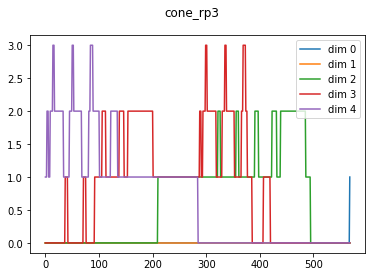

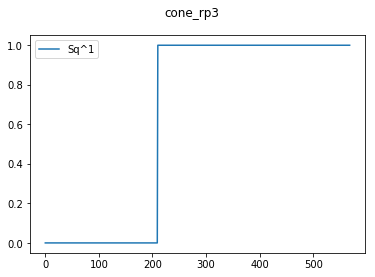

In [17]:
name = 'cone_rp3'
filtration = filtrations[name]
coboundary = get_coboundary(filtration)
reduced, triangular = get_reduced_triangular(coboundary)
barcode = get_barcode(reduced, filtration)
coho_reps = get_coho_reps(barcode, reduced, triangular, filtration)

for key, betti_curve in betti_curves(barcode, filtration).items():
    plot = plt.plot(range(len(filtration)), betti_curve, label=f'dim {key}')
    plt.legend()

plt.suptitle(f'{name}')    
plt.show()

k=1
steenrod_reps = get_steenrod_reps(k, coho_reps, filtration)
curve = steenrod_curve(barcode, steenrod_reps, filtration, reduced)
plot = plt.plot(range(len(filtration)), curve, label=f'Sq^{k}')
plt.legend()

plt.suptitle(f'{name}')    
plt.show()

In [ ]:
betti_curves_guigui(filtration)

## Main

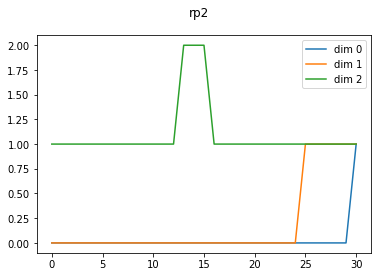

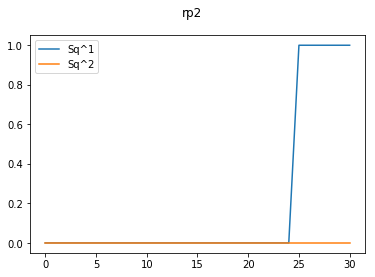

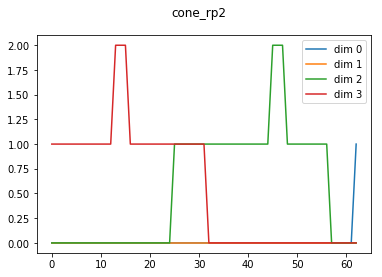

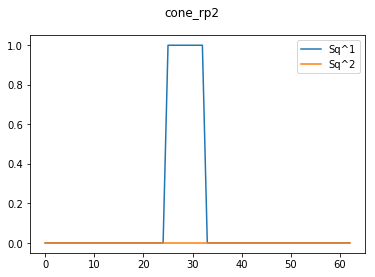

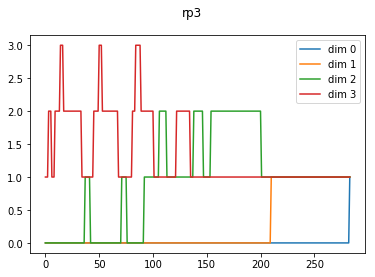

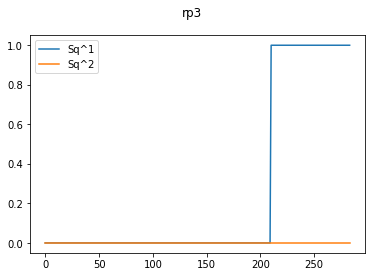

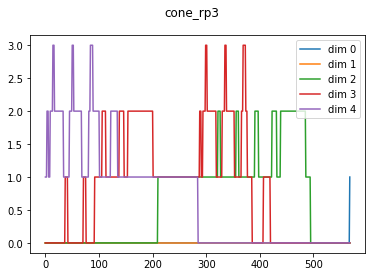

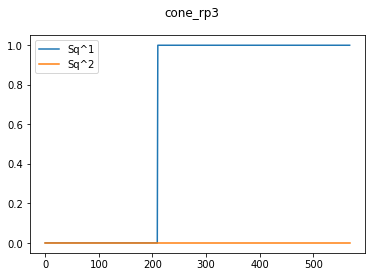

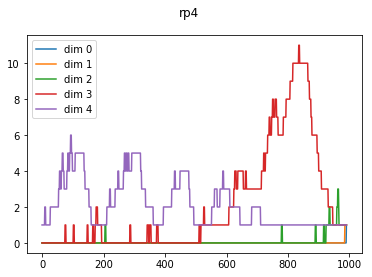

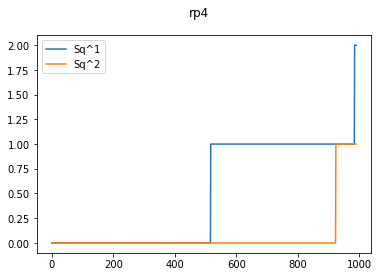

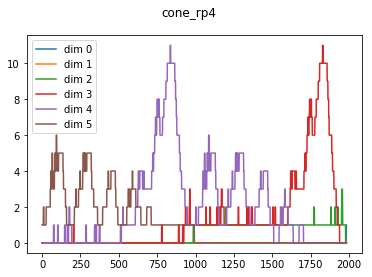

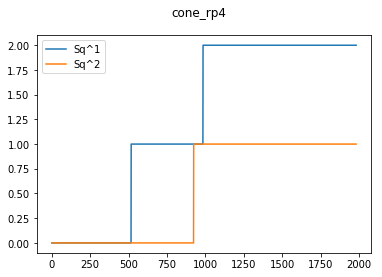

In [18]:
for name, filtration in filtrations.items():
    coboundary = get_coboundary(filtration)
    reduced, triangular = get_reduced_triangular(coboundary)
    barcode = get_barcode(reduced, filtration)
    coho_reps = get_coho_reps(barcode, reduced, triangular, filtration)

    for key, betti_curve in betti_curves(barcode, filtration).items():
        plot = plt.plot(range(len(filtration)), betti_curve, label=f'dim {key}')
        plt.legend()

    plt.suptitle(f'{name}')    
    plt.show()

    for k in range(1,3):
        steenrod_reps = get_steenrod_reps(k, coho_reps, filtration)
        curve = steenrod_curve(barcode, steenrod_reps, filtration, reduced)
        plot = plt.plot(range(len(filtration)), curve, label=f'Sq^{k}')
        plt.legend()

    plt.suptitle(f'{name}')    
    plt.show()